# PDEFind

SINDy was originally used to discover systems of ordinary differential equations (ODEs) but was quickly extended to search partial differential equations (PDEs), since many systems exhibit dependence in both space and time.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from sklearn.metrics import r2_score

import pysindy as ps
import pandas as pd

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

noises = [0.0, 0.001, 0.01, 0.1]

In [2]:
df = pd.DataFrame(columns=["dataset","model","noise","R2 Score"])

In [39]:
def diffuse (t, u, dx, nx):
    u = np.reshape(u, nx)
    du = ps.differentiation.SpectralDerivative(
            d=2, axis=0
         )._differentiate(u, dx)
    
    return np.reshape(u * du, nx)

In [40]:
N = 200
h0 = 1.0
L = 5
T = 1

t = np.linspace(0, T, N)
x = np.arange(0, N) * L / N

ep = 0.5 * h0
y0 = np.reshape(h0 + ep * np.cos(4 * np.pi / L * x)
                + ep * np.cos(2 * np.pi / L * x), N)
dx = x[1] - x[0]

sol = solve_ivp(diffuse, (t[0], t[-1]),
                y0=y0, t_eval=t, args=(dx, N),
                **integrator_keywords)

u_shaped_noiseless = np.reshape(sol.y, (N, N, 1))
u_dot_noiseless = ps.FiniteDifference(
    d=1, axis=1
)._differentiate(u_shaped_noiseless,t)

In [43]:
u_shaped_noiseless.shape, u_dot_noiseless.shape

((200, 200, 1), (200, 200, 1))

# Korteweg–De Vries equation

The Korteweg–De Vries (KdV) equation is a mathematical model of waves on shallow water surfaces. It is particularly notable as the prototypical example of an exactly solvable model, that is, a non-linear partial differential equation whose solutions can be exactly and precisely specified.

(201,) (512, 201) (512,)


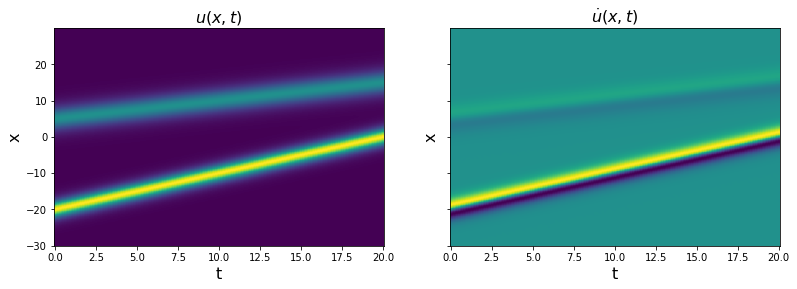


Noise: 0.0 R2 Score: 0.9971615270624993
(u)' = -0.992 u_111 + -5.967 uu_1


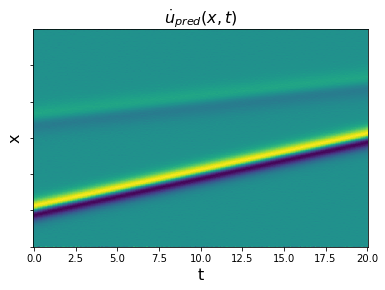


Noise: 0.001 R2 Score: 0.9637902370257259
(u)' = -0.912 u_1


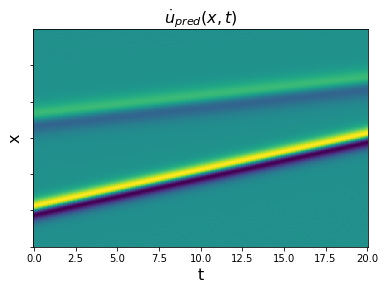


Noise: 0.01 R2 Score: 0.9400604645144752
(u)' = -6.031 uu_1 + -0.033 uu_11 + 8.929 uuu_11 + 0.049 uuu_111


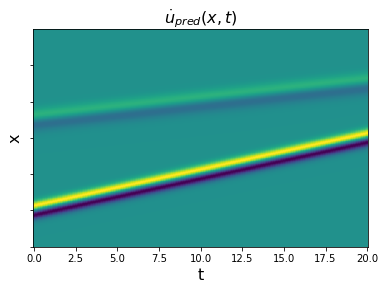


Noise: 0.1 R2 Score: 0.10493137549898268
(u)' = -0.592 uuu_11 + -0.003 uuu_111


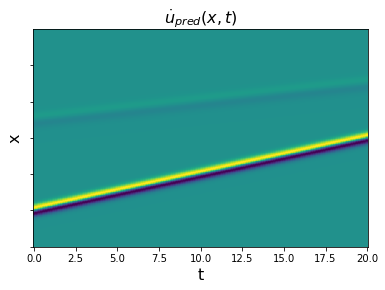

In [9]:
kdV = loadmat('data/kdv.mat')
t = np.ravel(kdV['t'])
x = np.ravel(kdV['x'])
u = np.real(kdV['usol'])

dt = t[1] - t[0]
dx = x[1] - x[0]

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
u_dot = u_dot.reshape(512, 201)

print(t.shape, u.shape, x.shape)
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

for noise in noises:

    u = u.reshape(len(x), len(t), 1)
    library_functions = [lambda x: x, lambda x: x * x]
    library_function_names = [lambda x: x, lambda x: x + x]
    pde_lib = ps.PDELibrary(library_functions=library_functions,
                            function_names=library_function_names,
                            derivative_order=3, spatial_grid=x,
                            include_bias=True, is_uniform=True)
    
    optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=["u"])
    model.fit(u + np.random.normal(0,noise,u.shape), t=dt)
    # model.print()

    u_pred = model.predict(u)
    u_pred = u_pred.reshape(u_pred.shape[0], u_pred.shape[1])
    u_true = u_dot.reshape(u_dot.shape[0], u_dot.shape[1])

    print(f'\nNoise: {noise} R2 Score: {r2_score(u_true, u_pred)}')
    model.print()
    df = df.append({"dataset":"d", "model":"m","noise":0.1, "R2 Score":0.99}, ignore_index=True)
    
    plt.pcolormesh(t, x, u_pred)
    plt.xlabel('t', fontsize=16)
    plt.ylabel('x', fontsize=16)
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.title(r'$\dot{u}_{pred}(x, t)$', fontsize=16)
    plt.show()


In [ ]:
# Load data from .mat file
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
u_dot = u_dot.reshape(u_dot.shape[0], u_dot.shape[1])


# plt.figure(figsize=(13, 4))
# plt.subplot(1, 2, 1)
# plt.pcolormesh(t, x, u_true)
# plt.xlabel('t', fontsize=16)
# plt.ylabel('x', fontsize=16)
# plt.title(r'$u(x, t)$', fontsize=16)

# plt.subplot(1, 2, 2)
# plt.pcolormesh(t, x, u_dot)
# plt.xlabel('t', fontsize=16)
# plt.ylabel('x', fontsize=16)
# ax = plt.gca()
# ax.set_yticklabels([])
# plt.title(r'$\dot{u}(x, t)$', fontsize=16)
# plt.show()

for noise in noises:

    u = u.reshape(len(x), len(t), 1)
    library_functions = [lambda x: x, lambda x: x * x]
    library_function_names = [lambda x: x, lambda x: x + x]
    pde_lib = ps.PDELibrary(library_functions=library_functions,
                            function_names=library_function_names,
                            derivative_order=3, spatial_grid=x,
                            include_bias=True, is_uniform=True)
    
    optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=["u"])
    model.fit(u + np.random.normal(0,noise,u.shape), t=dt)
    # model.print()

    u_pred = model.predict(u)
    u_pred = u_pred.reshape(u_pred.shape[0], u_pred.shape[1])
    u_true = u_dot.reshape(u_dot.shape[0], u_dot.shape[1])

    print(f'\nNoise: {noise} R2 Score: {r2_score(u_true, u_pred)}')
    model.print()
    df = df.append({"dataset":"d", "model":"m","noise":0.1, "R2 Score":0.99}, ignore_index=True)
    
#     plt.pcolormesh(t, x, u_pred)
#     plt.xlabel('t', fontsize=16)
#     plt.ylabel('x', fontsize=16)
#     ax = plt.gca()
#     ax.set_yticklabels([])
#     plt.title(r'$\dot{u}_{pred}(x, t)$', fontsize=16)
#     plt.show()

In [ ]:
data = loadmat('data/nse.mat')
data['t'][:, 0].shape

In [33]:
data = loadmat('data/nse.mat')
data.keys()
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
t.reshape(t.shape[0], 1).shape

u = u.reshape(len(t), len(x), 1)
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3, spatial_grid=x,
                        include_bias=True, is_uniform=True)

optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=["u", "x"])
model.fit(u + np.random.normal(0,noise,u.shape), t=dt)
model.print()

u_pred = model.predict(u)
u_pred = u_pred.reshape(u_pred.shape[0], u_pred.shape[1])
u_true = u_dot.reshape(u_dot.shape[0], u_dot.shape[1])


(u)' = -0.011 1 + -0.034 uu + -0.234 u_1 + 0.022 uu_1 + -0.036 uuu_11


In [38]:
u_true[0][:5], u_pred[0][:5]

(array([0.08375729, 0.08542523, 0.0871096 , 0.08882716, 0.09057856]),
 array([-0.08155285, -0.05676774, -0.02783484,  0.00172761,  0.02777983]))

In [34]:
r2_score(u_true, u_pred)
# u_true.shape, u_pred.shape

-8.183740200768134e+22

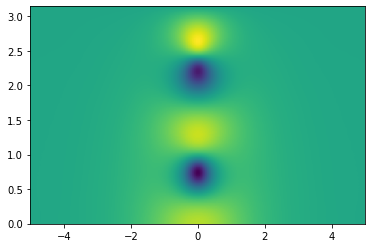

In [17]:
plt.pcolormesh(x, t, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.show()